In [1309]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

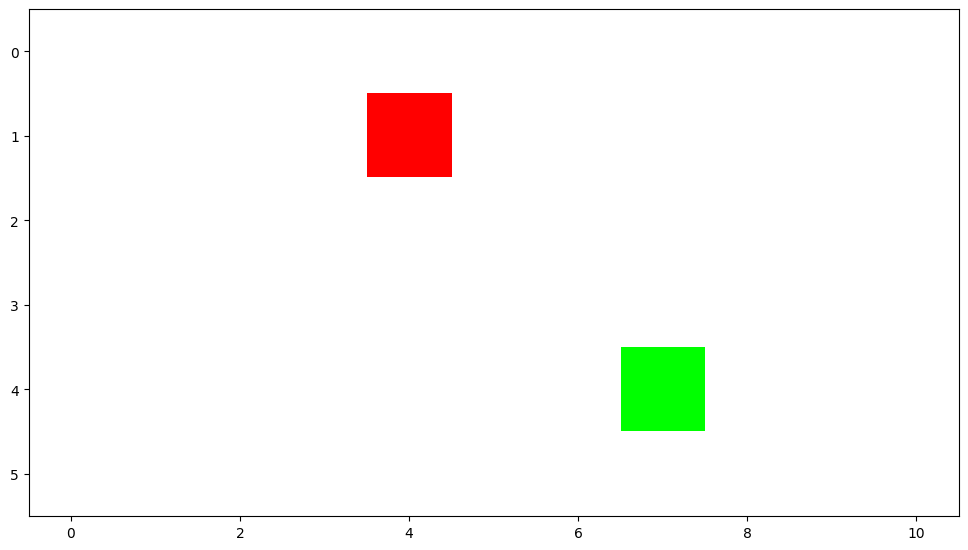

In [1310]:
img = np.asarray(Image.open('pic4.png'))
plt.rcParams['figure.figsize'] = [12, 12]
imgplot = plt.imshow(img)

#### Class `Point`
Definiert einen Punkt mit folgenden Parametern:
- `x`: x-Position des Punktes
- `y`: y-Position des Punkter
- `g_cost`: Der Kostenwert um diesen Punkt zu erreichen
- `h_cost`: Der Kostenwert um diesen Punkt zu erreichen
- `f_cost`: Der Kostenwert um diesen Punkt zu erreichen
- `isActive`: Besagt ob der Punkt aktiv ist bzw. ob er für den Pfad relevant ist
- `distanceToTarget`: Ist die Distanz zum Ziel

In [1311]:
class Point:
    def __init__(self, x, y, g_cost=0, h_cost=0, isVisited=False):
        self.x = x
        self.y = y
        self.g_cost = g_cost #distance from starting point
        self.h_cost = h_cost #distance form end point
        self.f_cost = g_cost + h_cost #sum of H cost and G cost
        self.isVisited = isVisited,
    
    def updateCost(self, g_cost, h_cost):
        self.g_cost = g_cost
        self.h_cost = h_cost
        self.f_cost = g_cost + h_cost



#### Function `getPointByColor`
Gibt einen Punkt zurück, welcher die entsprechende Farbe hat. Es wird nur der letzte gefundene Punkt zurückgegeben.
- `r`: Rotwert von 0-255
- `g`: Grünwert von 0-255
- `b`: Blauwert von 0-255
- `image`: Bildarray in dem der Punkt gesucht werden soll

In [1312]:
def getPointByColor(r, g, b, image):
    x, y = 0, 0
    for idi, i in enumerate(image):
        for idj, j in enumerate(i):
            if j[0] == r and j[1] == g and j[2] == b:
               x = idj
               y = idi
    return Point(x ,y)


Der grüne Startpunkt und der rote Zielpunkt wird mithilfe der Funktion `getPointByColor` definiert.

In [1313]:
startPoint = getPointByColor(0, 255, 0, img)
endPoint = getPointByColor(255, 0, 0, img)
print(f'StartPoint = {startPoint}\nEndPoint = {endPoint}')

StartPoint = <__main__.Point object at 0x1750ecdc0>
EndPoint = <__main__.Point object at 0x1750ee590>


#### Function `isWall`
Gibt zurück, ob entsprechneder Punkt eine Wand ist oder nicht. Wenn die Farbe des Punktes in allen drei Farben einen geringeren Wert als 128 aufweisst, wird er als Wand definiert.
- `point:Point`: Punkt der auf eine Wand geprüft werden soll.
- `image`: Bildarray auf dem der Punkt ist

In [1314]:
def isWall(point:Point, image):
    x = point.x
    y = point.y
    if image[y][x][0] < 128 and image[y][x][1] < 128 and image[y][x][2] < 128: return True
    else: return False


def getDistance(pointStart:Point, pointTarget:Point):
    return np.sqrt(np.abs(pointStart.x-pointTarget.x)**2 + np.abs(pointStart.y-pointTarget.y)**2)

#### Function `getNextPoints`
Gibt eine List von Punkten zurück, die vom gegebenen Punkt benachbart sind. Wenn ein benachbarter Punkt eine Wand darstellt, wird dieser ignoriert.
- `point:Point`: Punkt von dem aus die benachbarten Punkte gesucht werden
- `image`: Bildarray auf dem der Punkt ist

In [1315]:
def getNextPoints(point:Point, image):
    x = point.x
    y = point.y
    maxPos = image.shape
    nextPoints = []
    for i in np.arange(-1,2,1):
        for j in np.arange(-1,2,1):
            if i != 0 or j != 0:
                xn = x+i
                yn = y+j
                if xn >= 0 and yn >= 0 and xn <= maxPos[1] and yn <= maxPos[0] and not isWall(Point(xn, yn), image):
                    if x != startPoint.x and x != endPoint.x and y != startPoint.y and y != endPoint.y:
                        nextPoints.append(Point(xn, yn))
    return nextPoints

In [1316]:
def isPointInList(point:Point, pointList:list[Point]):
    wasFound = False
    for p in pointList:
        if p.x == point.x and p.y ==point.y: wasFound = True
    return wasFound

In [1317]:
def getPointFromList(point:Point, pointList:list[Point]):
    for p in pointList:
        if p.x == point.x and p.y ==point.y: return p

#### Function `calculateNextPoints`
Gibt eine List von Punkten zurück, die benachbart sind vom gegeben Punkt und berechnet die Kosten um den Punkt zu erreichen und berechnet die Distanz zum Zielpunkt.
- `point:Point`: Punkt von dem aus die benachbarten Punkte berechnet werden
- `image`: Bildarray auf dem der Punkt ist
- `precision`: Auf wieviele Stellen nach dem Komma gerundet werden soll bezüglich der Kosten

In [1318]:
def calculateNextPoints(point:Point, image, pointList:list[Point]=[], precision=1):
    distance = 10.0
    distanceDiagonal = 14# np.sqrt(distance**2 + distance**2)
    nextPoints = getNextPoints(point, image)

    
    for p in nextPoints:
        cost = 0.0
        if p.x != point.x and p.y != point.y:
            cost = round(distanceDiagonal,precision)
        else:
            cost = distance

        distanceToTarget = getDistance(p, endPoint)
        distanceToStart = getDistance(p, startPoint)

        if not isPointInList(p, pointList):
            pointList.append(Point(p.x, p.y, distanceToStart, distanceToTarget))
        

    return pointList

In [1319]:
def plotImage(image, points):
    for point in points:
        label = f'{round(point.g_cost,1)}   {round(point.h_cost,1)}'
        plt.text(point.x, point.y, label, ha='center',va='bottom',fontsize=10)
        label = f'{round(point.f_cost,1)}'
        plt.text(point.x, point.y, label, ha='center',va='top',fontsize=14)

    plt.imshow(image)

In [1320]:
def getClosestPointToTarget(points:list[Point]):
    bestPoint:Point = Point
    minDistanceToTarget = float('inf')
    for point in points:
        if point.h_cost < minDistanceToTarget:
            minDistanceToTarget = point.h_cost
            bestPoint = point

    return bestPoint

In [1321]:
nextPoints = calculateNextPoints(startPoint, img)

distanceToTarget = 99999999
iterations = 0
MAX_ITERATION = 1000

while distanceToTarget > 1.5 and iterations < MAX_ITERATION:
    point = getClosestPointToTarget(nextPoints)
    point.isVisited = True

    distanceToTarget = point.h_cost
    nextPoints = calculateNextPoints(point, img, nextPoints)
    iterations+= 1

plotImage(img, nextPoints)
print(iterations)

for p in nextPoints:
    print(f'x={p.x}\ty={p.y}\tv={p.isVisited}')
    if p.isVisited is True:
        plt.scatter(x=[p.x], y=[p.y], c='orange', marker='s', s=2000)
    else:
        plt.scatter(x=[p.x], y=[p.y], c='yellow', marker='s', s=2000)

AttributeError: type object 'Point' has no attribute 'h_cost'